 ---- Stamatis Outsios ----

# Google QUEST Q&A Labeling

# Improving automated understanding of complex question answer content

## Experiments with Recurrence over BERT

In [3]:
import pandas as pd
import numpy as np
#from numba import cuda
from nltk.corpus import stopwords
#from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
#from ml_stratifiers import MultilabelStratifiedShuffleSplit, MultilabelStratifiedKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow_hub as hub
import tensorflow as tf
from bert import bert_tokenization
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import os, gc, datetime, pickle, math, re, html, multiprocessing
from scipy.stats import spearmanr
from math import floor, ceil
from gensim.summarization import summarize

In [4]:
def _get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))


def _get_segments(tokens, max_seq_length):
    #stoken = ["[CLS]"] + title + question + ["[SEP]"] + answer + ["[SEP]"]
    
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    first_sep = False
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            if first_sep:
                first_sep = False 
            else:
                current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

def _get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids


def _trim_input(tokens_a, tokens_b, max_length,i):
    """Truncates a sequence pair in place to the maximum length."""
    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    k=0
    li=-1
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()
        k=1
        li=i
    return k,li


def _convert_to_bert_inputs(title,  question, answer, tokenizer, max_sequence_length, stoken):
    """Converts tokenized input to ids, masks and segments for BERT"""
    
    if stoken=='q':
        stoken = ["[CLS]"] + question + ["[SEP]"] #for question target prediction
    if stoken=='a':
        #stoken = ["[CLS]"] + question + ["[SEP]"] + answer + ["[SEP]"] #for answer target prediction
        stoken = ["[CLS]"] + answer + ["[SEP]"]
        
    input_ids = _get_ids(stoken, tokenizer, max_sequence_length)
    input_masks = _get_masks(stoken, max_sequence_length)
    input_segments = _get_segments(stoken, max_sequence_length)

    return [input_ids, input_masks, input_segments]

def compute_input_arays(df, columns, tokenizer, max_sequence_length, part):
    input_ids, input_masks, input_segments = [], [], []
    mm = 0
    large=[]
    for i, instance in tqdm(df[columns].iterrows()):
        t, q, a, c = instance.question_title, instance.question_body, instance.answer, instance.category
        
        t = tokenizer.tokenize(t)
        q = tokenizer.tokenize(q)
        a = tokenizer.tokenize(a)
        c = tokenizer.tokenize(c)
        
        if part=='q':
            q = t+q
            a = [] #for question only input
            #t, q, a, maxes = _trim_input(t, q, a, max_sequence_length)
            maxes, li = _trim_input(q, a, max_sequence_length-2, i)
        if part=='a':
            q = []
            #q=t+q
            #t, q, a, maxes = _trim_input(t, q, a, max_sequence_length)
            maxes, li = _trim_input(q, a, max_sequence_length-2, i)
            
        ids, masks, segments = _convert_to_bert_inputs(t, q, a, tokenizer, max_sequence_length, stoken=part)
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)
        try:
            mm += maxes
        except:
            pass
        if li>-1:
            large.append(li)
    print('#>512:', mm)
    print('#>512 list length:', len(large))
    print('#>512 list:', large)
    return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)]

def compute_output_arrays(df, columns):
    return np.asarray(df[columns])

def compute_output_arrays_qa(df):
    return np.asarray(df.iloc[:,:21]), np.asarray(df.iloc[:,21:])

In [5]:
def compute_spearmanr(trues, preds):
    rhos = []
    for col_trues, col_pred in zip(trues.T, preds.T):
        rhos.append(
            spearmanr(col_trues, col_pred + np.random.normal(0, 1e-7, col_pred.shape[0])).correlation)
            #spearmanr(col_trues, col_pred).correlation)
    return np.mean(rhos)

In [6]:
def sploss(y_pred, y_true):
    return spearmanr(y_true, y_pred)

In [7]:
def correlation(x, y):    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))        
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    return r_num / r_den

In [8]:
class SpearmanRhoCallback(Callback):
    def __init__(self, training_data, validation_data, patience, model_name):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        
        self.patience = patience
        self.value = -1
        self.bad_epochs = 0
        self.model_name = model_name

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred_val = self.model.predict(self.x_val)
        rho_val = compute_spearmanr(self.y_val, y_pred_val)
        if rho_val >= self.value:
            self.value = rho_val
            if self.fold is not None:
                self.model.save_weights(f'/training_test/bert-base-{fold}-{epoch}.h5py')
                print('\nSaving model..')
        else:
            self.bad_epochs += 1
        if self.bad_epochs >= self.patience:
            print("Epoch %05d: early stopping Threshold" % epoch)
            self.model.stop_training = True

        print('\rval_spearman-rho: %s' % (str(round(rho_val, 4))), end=100*' '+'\n')
        return rho_val

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [9]:
rho = []
class CustomCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, valid_inputs, valid_outputs, patience, model_name, pred, batch_size=16, fold=None):
        self.valid_inputs = valid_inputs
        self.valid_outputs = valid_outputs
        self.batch_size = batch_size
        self.pred = pred
        
        self.patience = patience
        self.value = -1
        self.bad_epochs = 0
        self.fold = fold
        self.model_name = model_name
       
    def on_train_begin(self, logs={}):
        self.valid_predictions = []
        return
        
    def on_epoch_end(self, epoch, logs={}):
        
        if self.pred=='bert':
            rho_val = compute_spearmanr(
            self.valid_outputs, self.model.predict(self.valid_inputs, batch_size=self.batch_size))
        
        if self.pred=='lstm':
            rho_val = compute_spearmanr(
            self.valid_outputs, self.model.predict(val_generator(self.valid_inputs, self.valid_outputs),
                                                   steps=76, callbacks=None, max_queue_size=10,
                                                   workers=1, use_multiprocessing=False, verbose=0))

        if rho_val >= self.value:
            self.value = rho_val
            if self.fold is not None:
                print('\nSaving model..',self.model_name)
                self.model.save_weights(self.model_name)
        else:
            self.bad_epochs += 1
        if self.bad_epochs >= self.patience:
            print("Epoch %05d: early stopping Threshold" % epoch)
            self.model.stop_training = True
        rho.append("%.3f" % rho_val)
        print("\nvalidation rho: %.3f" % rho_val)
        return

In [10]:
def my_func(arg):
    arg = tf.convert_to_tensor(arg, dtype=tf.float32)
    return tf.matmul(arg, arg) + arg

In [11]:
def bert_model(units=30, dropout=0.3):
    tf.random.set_seed(1234) #tf2
        
    input_word_ids = tf.keras.layers.Input(
        (MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_word_ids')
    input_masks = tf.keras.layers.Input(
        (MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_masks')
    input_segments = tf.keras.layers.Input(
        (MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_segments')
    
    bert_inputs = [input_word_ids, input_masks, input_segments]
    

    bert_layer = hub.KerasLayer(BERT_PATH, trainable=True)
    pooled_output, sequence_output = bert_layer(bert_inputs)
    
    x = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
        
    out = tf.keras.layers.Dense(units, activation='sigmoid', name='dense_output')(x)
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=out)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5))
    return model

In [12]:
# Params for bert model and tokenization
BERT_PATH = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"

In [13]:
def create_tokenizer(bert_path):
    bert_layer = hub.KerasLayer(bert_path, trainable=True)
    bert_layer.resolved_object.do_lower_case.numpy()
    vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
    do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
    tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)
    return tokenizer

In [14]:
tokenizer = create_tokenizer(BERT_PATH)

In [15]:
tokenizer.tokenize('Hello, BERT-World!')

['hello', ',', 'bert', '-', 'world', '!']

In [16]:
MAX_SEQUENCE_LENGTH = 512

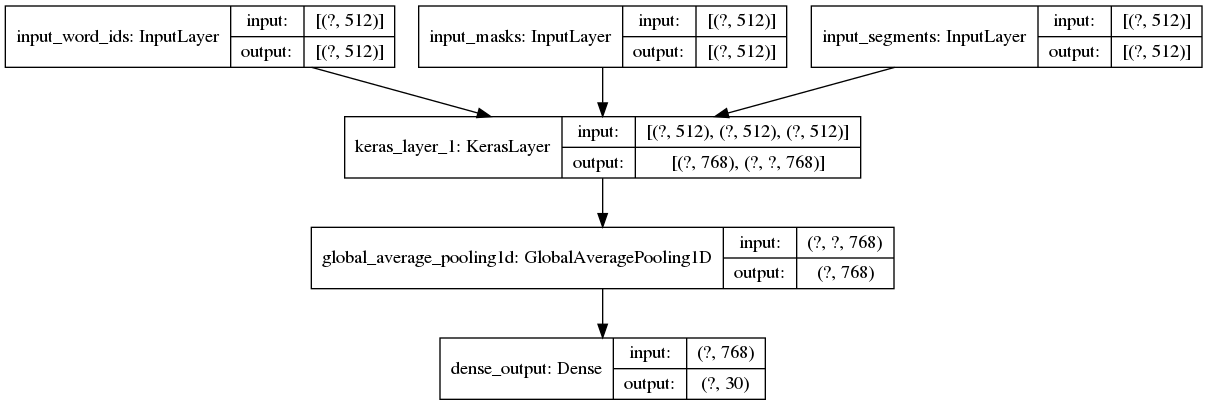

In [17]:
model = bert_model()
plot_model(model, to_file='model.png', show_shapes=True)
Image('model.png')

In [18]:
PATH ='./'

In [19]:
df_train = pd.read_csv(PATH+'train.csv')
df_test = pd.read_csv(PATH+'test.csv')
df_sub = pd.read_csv(PATH+'sample_submission.csv')
print('train shape =', df_train.shape)
print('test shape =', df_test.shape)
print('sub shape =', df_sub.shape)

train shape = (6079, 41)
test shape = (476, 11)
sub shape = (476, 31)


In [20]:
df_train, df_hold = train_test_split(df_train, test_size=0.1, random_state=42)

In [21]:
output_categories = list(df_train.columns[11:])
input_categories = list(df_train.columns[[1,2,5,9]])
print('\noutput categories:\n\t', len(output_categories), output_categories)
print('\ninput categories:\n\t', len(input_categories), input_categories)


output categories:
	 30 ['question_asker_intent_understanding', 'question_body_critical', 'question_conversational', 'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer', 'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice', 'question_type_compare', 'question_type_consequence', 'question_type_definition', 'question_type_entity', 'question_type_instructions', 'question_type_procedure', 'question_type_reason_explanation', 'question_type_spelling', 'question_well_written', 'answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance', 'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 'answer_type_reason_explanation', 'answer_well_written']

input categories:
	 4 ['question_title', 'question_body', 'answer', 'category']


In [22]:
len(output_categories)

30

In [23]:
df_train['category'].value_counts()

TECHNOLOGY       2195
STACKOVERFLOW    1139
CULTURE           862
LIFE_ARTS         641
SCIENCE           634
Name: category, dtype: int64

In [24]:
df_train['host'].value_counts()[:20]

stackoverflow.com                1139
english.stackexchange.com         206
superuser.com                     204
electronics.stackexchange.com     197
serverfault.com                   187
math.stackexchange.com            165
physics.stackexchange.com         143
askubuntu.com                     123
tex.stackexchange.com             116
rpg.stackexchange.com             113
programmers.stackexchange.com     110
gaming.stackexchange.com           99
apple.stackexchange.com            95
ux.stackexchange.com               95
academia.stackexchange.com         93
unix.stackexchange.com             92
photo.stackexchange.com            92
drupal.stackexchange.com           90
scifi.stackexchange.com            87
diy.stackexchange.com              84
Name: host, dtype: int64

In [25]:
df_train.columns

Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host', 'question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfa

In [26]:
df_test.columns

Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host'],
      dtype='object')

In [27]:
df_train.shape, df_hold.shape, df_test.shape

((5471, 41), (608, 41), (476, 11))

In [28]:
pd.options.display.max_colwidth = 50

In [29]:
df_train.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
2313,3690,Quantity based discount for single product in ...,"I'm using latest build of Expresso Store, 2.3....",neekster,https://expressionengine.stackexchange.com/use...,We've just had the bulk discount configured to...,Jos Medinger,https://expressionengine.stackexchange.com/use...,http://expressionengine.stackexchange.com/ques...,TECHNOLOGY,...,0.777778,0.888889,0.666667,1.0,1.000000,0.800000,0.333333,1.000000,0.666667,0.888889
4222,6735,migrating a document library from sharepoint 2...,I have to migrate a document library from shar...,Rajesh Singh,https://sharepoint.stackexchange.com/users/29819,Their are 3 ways to get this done.\n\n\nExport...,Waqas Sarwar MVP,https://sharepoint.stackexchange.com/users/21563,http://sharepoint.stackexchange.com/questions/...,TECHNOLOGY,...,1.000000,1.000000,1.000000,1.0,1.000000,0.900000,0.666667,0.333333,0.333333,1.000000
5346,8488,Do Not Track header,Does Stack Overflow honor the Do not track hea...,user155454,https://meta.stackexchange.com/users/155454,We do not do anything special for the proposed...,waffles,https://meta.stackexchange.com/users/17174,http://meta.stackexchange.com/questions/109726...,TECHNOLOGY,...,0.333333,1.000000,0.666667,1.0,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
227,364,Change Product Quantity Without Edit on Magento,"I have a question here, how to change product ...",Reggie Trichandra P,https://magento.stackexchange.com/users/23144,There are third party modules for that.\n\nTak...,Jeroen,https://magento.stackexchange.com/users/3156,http://magento.stackexchange.com/questions/597...,TECHNOLOGY,...,0.777778,0.777778,0.444444,1.0,0.888889,0.666667,1.000000,0.000000,0.000000,0.888889
3830,6094,Using \item within \newcommand,I tried defining a new command \Quest as follo...,Grandfather,https://tex.stackexchange.com/users/27625,Something's wrong--perhaps a missing \item\n\n...,David Carlisle,https://tex.stackexchange.com/users/1090,http://tex.stackexchange.com/questions/103200/...,TECHNOLOGY,...,0.333333,1.000000,0.666667,1.0,1.000000,0.900000,0.500000,0.000000,0.500000,0.833333


In [30]:
def clean_txt(string):
    #string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)     
    string = re.sub(r"\'s", " \'s", string) 
    string = re.sub(r"\'ve", " \'ve", string) 
    string = re.sub(r"n\'t", " n\'t", string) 
    string = re.sub(r"\'re", " \'re", string) 
    string = re.sub(r"\'d", " \'d", string) 
    string = re.sub(r"\'ll", " \'ll", string) 
    string = re.sub(r",", " , ", string) 
    string = re.sub(r"!", " ! ", string) 
    string = re.sub(r"\(", " \( ", string) 
    string = re.sub(r"\)", " \) ", string) 
    string = re.sub(r"\?", " \? ", string) 
    #string = re.sub(r"\s{2,}", " ", string)
    return string
    #return string.strip().split()

In [31]:
df_train['answer'][:10]

2313    We've just had the bulk discount configured to...
4222    Their are 3 ways to get this done.\n\n\nExport...
5346    We do not do anything special for the proposed...
227     There are third party modules for that.\n\nTak...
3830    Something's wrong--perhaps a missing \item\n\n...
4315    I'm not sure where the "not interest" part of ...
1242    The error is most likely that you are using \n...
2691    I can't test it right now, but it should be po...
2447    There's an old post (from 2012) here which mig...
3049    Well this is still very broad but to try and h...
Name: answer, dtype: object

In [32]:
def clean_txt_q(text):
    text = re.sub('&lt;div.*?&lt;/p&gt;', '', text) #only for questions
    text = re.sub('http\S+|https\S+', '', text)    #only for questions
    
    text=re.sub(r"\s+", " ", text)
    cleanr = re.compile('<.*?>')
    text = re.sub(cleanr, ' ', text)        #Removing HTML tags
    text = re.sub("'", "",text)
    text = re.sub(",", "",text)
    text=re.sub("(\\W)+"," ",text)
    return text

In [33]:
def clean_txt_a(text):
    text = re.sub('&lt;div.*?&lt;/p&gt;', '', text) #only for questions
    text = re.sub('http\S+|https\S+', '', text)    #only for questions

    text=re.sub(r"\s+", " ", text)    
    cleanr = re.compile('<.*?>')
    text = re.sub(cleanr, ' ', text)        #Removing HTML tags
    text = re.sub("'", "",text)
    text = re.sub(",", "",text)
    text=re.sub("(\\W)+"," ",text)
    return text

In [34]:
def clean_data_q(df, columns: list):
    df1=df.copy()
    for col in columns:
        df1[col] = df1[col].apply(lambda x: clean_txt_q(x))
    return df1

In [35]:
def clean_data_a(df, columns: list):
    df1=df.copy()
    for col in columns:
        df1[col] = df1[col].apply(lambda x: clean_txt_a(x))
    return df1

In [36]:
df_train_q = clean_data_q(df_train, input_categories)
df_train_a = clean_data_a(df_train, input_categories)

In [37]:
df_train_q.shape, df_train_a.shape, 

((5471, 41), (5471, 41))

In [38]:
df_hold_q = clean_data_q(df_hold, input_categories)
df_hold_a = clean_data_a(df_hold, input_categories)

In [39]:
df_hold_q.shape, df_hold_a.shape, 

((608, 41), (608, 41))

# Some stats

## Statistics for sentences

In [40]:
def avg_word(sentence):
    words = sentence.split()
    if len(words) != 0:
        return sum(len(word) for word in words)/len(words)

In [41]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

## Mean tokens per sentence

In [42]:
df_train['question_title'].str.split().str.len().mean()

9.045147139462621

In [43]:
df_train['question_body'].str.split().str.len().mean()

125.49972582708828

In [44]:
df_train['answer'].str.split().str.len().mean()

133.63388777188814

## Tokens per sentence distribution

<AxesSubplot:ylabel='Frequency'>

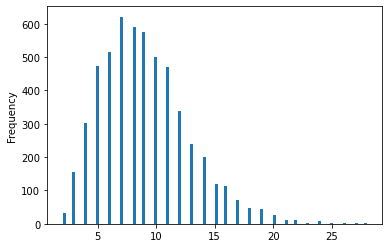

In [45]:
#other['question_body_word_count'] = df_train.question_body.apply(lambda x: len(x.split()))
df_train.question_title.apply(lambda x: len(x.split())).plot(kind='hist',bins=100)

<AxesSubplot:ylabel='Frequency'>

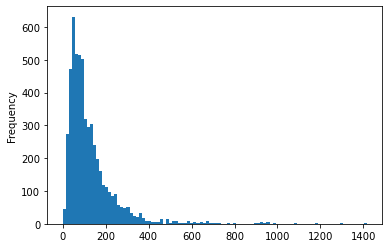

In [46]:
df_train.question_body.apply(lambda x: len(x.split())).plot(kind='hist',bins=100)

In [47]:
df_train[df_train['question_body'].apply(lambda x: len(x.split())>400)]['question_body'][:]

4292    There has been a tug-of-war in the hot-questio...
5714    I have a iMac 27" late 2012, OS X 10.8.4 and l...
149     Voldemort hid one of his Horcruxes inside Hogw...
2024    I've created this view that is painfully slow ...
5044    I worked JSON. I have two classes (private cla...
                              ...                        
5496    I have a 500GB Toshiba 2.5' HD, which I format...
4488    I have been working on a new project. The proj...
1495    On both wired and wireless connections, I can ...
5463    I have a problem that is bugging me for a coup...
2061    I have an idea of build centered around the Cr...
Name: question_body, Length: 148, dtype: object

There are 148 examples with question_body column longer than 400 tokens! An example follows:

In [48]:
print(df_train[df_train['question_body'].apply(lambda x: len(x.split())>400)]['question_body'][149])

Voldemort hid one of his Horcruxes inside Hogwarts. It seemed to be relying on security through obscurity as far as protecting it. But as we know, it ended up not being so secure because it wasn't so obscure - Harry Potter knew about the Room of Hidden Things.

My question is, the way Rowling describes this hints at the fact that Riddle had an assumption that very few people would ever stumble upon that room. *WHY???



First, let's show Harry's theory on what Voldemort was thinking, how and why:

Here's Harry understanding Voldemort's thinking in HP7 once he figured out where the Diadem was (bold emphasis mine):


  Tom Riddle, who confided in no one and operated alone, might have been arrogant
  enough to assume that he, and only he, had penetrated the deepest mysteries of
  Hogwarts Castle. Of course, Dumbledore and Flitwick, those model pupils, had never
  set foot in that particular place, but he, Harry, had strayed off the beaten track in his
  time at school – here at least was 

<AxesSubplot:ylabel='Frequency'>

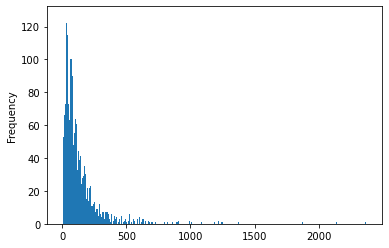

In [49]:
#other['answer_word_count'] = df_train.answer.apply(lambda x: len(x.split()))
df_train.answer.apply(lambda x: len(x.split())).plot(kind='hist', bins=1000)

## Characters per word per sentence distribution

<AxesSubplot:ylabel='Frequency'>

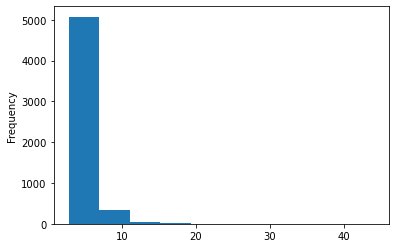

In [50]:
df_train.question_body.apply(lambda x: avg_word(x)).plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

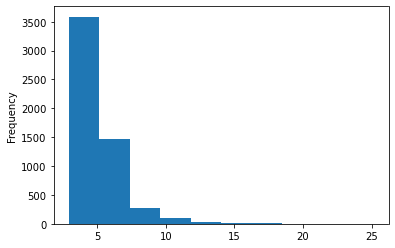

In [51]:
df_train.answer.apply(lambda x: avg_word(x)).plot(kind='hist')

# Split long texts

In [52]:
def get_split(text1, chunks=300, overlap=50): 
    stride = chunks-overlap
    l_total = []
    l_parcial = []
    n = len(text1.split())//stride +1
    for w in range(n):
        l_parcial = text1.split()[w*stride:w*stride + chunks]
        l_total.append(' '.join(l_parcial))
    return l_total

In [53]:
df_train_q['text_split_q'] = (df_train_q['question_title']+df_train_q['question_body']).apply(get_split)
df_train_q.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,text_split_q
2313,3690,Quantity based discount for single product in ...,Im using latest build of Expresso Store 2 3 1 ...,neekster,https://expressionengine.stackexchange.com/use...,Weve just had the bulk discount configured to ...,Jos Medinger,https://expressionengine.stackexchange.com/use...,http://expressionengine.stackexchange.com/ques...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.000000,0.800000,0.333333,1.000000,0.666667,0.888889,[Quantity based discount for single product in...
4222,6735,migrating a document library from sharepoint 2...,I have to migrate a document library from shar...,Rajesh Singh,https://sharepoint.stackexchange.com/users/29819,Their are 3 ways to get this done Export from ...,Waqas Sarwar MVP,https://sharepoint.stackexchange.com/users/21563,http://sharepoint.stackexchange.com/questions/...,TECHNOLOGY,...,1.000000,1.000000,1.0,1.000000,0.900000,0.666667,0.333333,0.333333,1.000000,[migrating a document library from sharepoint ...
5346,8488,Do Not Track header,Does Stack Overflow honor the Do not track hea...,user155454,https://meta.stackexchange.com/users/155454,We do not do anything special for the proposed...,waffles,https://meta.stackexchange.com/users/17174,http://meta.stackexchange.com/questions/109726...,TECHNOLOGY,...,1.000000,0.666667,1.0,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,[Do Not Track headerDoes Stack Overflow honor ...
227,364,Change Product Quantity Without Edit on Magento,I have a question here how to change product s...,Reggie Trichandra P,https://magento.stackexchange.com/users/23144,There are third party modules for that Take a ...,Jeroen,https://magento.stackexchange.com/users/3156,http://magento.stackexchange.com/questions/597...,TECHNOLOGY,...,0.777778,0.444444,1.0,0.888889,0.666667,1.000000,0.000000,0.000000,0.888889,[Change Product Quantity Without Edit on Magen...
3830,6094,Using item within newcommand,I tried defining a new command Quest as follow...,Grandfather,https://tex.stackexchange.com/users/27625,Somethings wrong perhaps a missing item Is a n...,David Carlisle,https://tex.stackexchange.com/users/1090,http://tex.stackexchange.com/questions/103200/...,TECHNOLOGY,...,1.000000,0.666667,1.0,1.000000,0.900000,0.500000,0.000000,0.500000,0.833333,[Using item within newcommandI tried defining ...


In [54]:
df_hold_q['text_split_q'] = (df_hold_q['question_title']+df_hold_q['question_body']).apply(get_split)

In [55]:
df_train_q.shape, df_hold_q.shape

((5471, 42), (608, 42))

In [56]:
df_train_q[['text_split_q']].head()

,text_split_q
2313,[Quantity based discount for single product in...
4222,[migrating a document library from sharepoint ...
5346,[Do Not Track headerDoes Stack Overflow honor ...
227,[Change Product Quantity Without Edit on Magen...
3830,[Using item within newcommandI tried defining ...


In [58]:
pd.set_option('display.max_colwidth', 300)

### Lets see an example of our text splitting:

In [59]:
df_train_q.loc[3649]['text_split_q']

['Not Proper Table Alignment in BootstrapIm trying to develop an application with help of Bootstrap in order to respect Desktop Tablet and Mobile Currently Im facing an issue with the table responsiveness Below I have provided the screenshot and the code kindly let me know where i do a mistake You can see from the second screenshot where the second getting aligned to responsiveness but the other not Screenshot 1 Perfect alignment on tablet Screenshot 2 Not perfect on mobile CODE lt DOCTYPE html gt lt html lang en gt lt head gt lt meta charset utf 8 gt lt meta content IE edge gt lt meta name viewport content width device width initial scale 1 gt lt meta name description content gt lt meta name author content gt lt link rel icon href favicon ico gt lt title gt Fixed Top Navbar Example for Bootstrap lt title gt lt Bootstrap core CSS gt lt link href js libs bootstrap css bootstrap min css rel stylesheet gt lt Custom styles for this template gt lt link href js libs bootstrap customcss navba

# Make the examples for LSTM

In [61]:
def lstmize(df, col):
    train = []
    label = []
    index =[]
    for idx,row in df.iterrows():
        for l in row[col]:
            train.append(l)
            label.append(row[output_categories])
            index.append(idx)
    #print(len(train),len(label),len(index))
    print('Number of examples after splitting in segments for LSTM use:', len(train))
    df_lstm = pd.DataFrame(label) 
    df_lstm['index']=index
    df_lstm['question_body']=train
    header_list=['question_title', 'answer', 'category']
    for i in header_list:
        df_lstm[i]=' '
    return df_lstm

In [62]:
df_train_q_lstm = lstmize(df_train_q,'text_split_q')

Number of examples after splitting in segments for LSTM use: 6364


In [63]:
df_train_q_lstm

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,...,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,index,question_body,question_title,answer,category
2313,1.000000,0.555556,0.0,0.000000,1.000000,0.666667,0.777778,0.555556,1.000000,0.0,...,0.800000,0.333333,1.000000,0.666667,0.888889,2313,Quantity based discount for single product in Expresso StoreIm using latest build of Expresso Store 2 3 1 I need to apply quantity based discounts to products but the discount needs to apply to a single product For example I have 10 off discount for all products in store when you order 10 or mor...,,,
4222,0.888889,0.888889,0.0,1.000000,0.666667,1.000000,0.666667,0.444444,0.000000,0.0,...,0.900000,0.666667,0.333333,0.333333,1.000000,4222,migrating a document library from sharepoint 2010 to sharepoint 2013 without using 3rd party toolsI have to migrate a document library from sharepoint 2010 to sharepoint 2013 without using any 3rd party tool any nice approach to achieve it,,,
5346,0.777778,0.333333,0.0,1.000000,0.333333,1.000000,0.666667,0.333333,0.000000,0.0,...,1.000000,0.000000,0.000000,1.000000,1.000000,5346,Do Not Track headerDoes Stack Overflow honor the Do not track header or is support going to be added later it doesnt seem to honor the header at the moment,,,
227,0.666667,0.888889,0.0,1.000000,1.000000,1.000000,0.666667,0.444444,0.000000,0.0,...,0.666667,1.000000,0.000000,0.000000,0.888889,227,Change Product Quantity Without Edit on MagentoI have a question here how to change product stock without click Edit on Magento Thanks Before,,,
3830,0.777778,0.333333,0.0,1.000000,0.333333,1.000000,0.555556,0.333333,0.000000,0.0,...,0.900000,0.500000,0.000000,0.500000,0.833333,3830,Using item within newcommandI tried defining a new command Quest as follows but the error Lonely item perhaps a missing list environment appears def solnversion 0 set this to 1 to get solutions newcommand Quest 3 item ifnum solnversion 1 3 else 2 fi But if the item command is removed the error S...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,1.000000,0.333333,0.0,1.000000,1.000000,1.000000,0.333333,0.333333,1.000000,0.0,...,1.000000,1.000000,0.000000,1.000000,1.000000,5191,lxc create hangs and finally failsI was trying to place some juju charms on linux containers and the containers failed to start To debug the issue I sshed into the node where this happened and tried creating an LXC container manually like ubuntu slot13 sudo lxc create t ubuntu n pavan Checking c...,,,
5226,1.000000,0.444444,0.0,0.666667,0.666667,1.000000,0.555556,0.666667,0.000000,0.0,...,0.933333,1.000000,0.000000,1.000000,0.888889,5226,Noise canceling headphones make strange sound when I touch my MacBook ProIve got headphones plugged into my desktop and a laptop nearby that I use for work as well Whenever I touch my MacBook Pro with the noise canceling on my headphones turned on it makes my headphones go nuts creating a lot of...,,,
5390,1.000000,0.666667,0.0,1.000000,0.333333,1.000000,0.555556,0.444444,0.333333,0.0,...,0.900000,0.333333,0.000000,1.000000,0.888889,5390,Apple Push Notification all messages get sent but not all get deliveredI have a problem with sending Apple Push Notifications When I send a message to two devices only everything is working But When I send a message to all devices in the Database then not all Push Message get delivered but I get...,,,
860,0.888889,0.333333,0.0,0.666667,0.333333,1.000000,0.444444,0.333333,0.000000,0.0,...,1.000000,1.000000,0.000000,0.333333,0.888889,860,Two sets came to an intersectionChallenge Print set intersections Specifications Your program should accept as its first argument a path to a 

In [65]:
df_hold_q_lstm = lstmize(df_hold_q,'text_split_q')

Number of examples after splitting in segments for LSTM use: 707


In [66]:
print(df_train_q_lstm.shape, df_hold_q_lstm.shape)
print(df_train_q_lstm[output_categories].shape, df_hold_q_lstm[output_categories].shape)

(6364, 35) (707, 35)
(6364, 30) (707, 30)


In [67]:
list(df_train_q_lstm.columns[:])

['question_asker_intent_understanding',
 'question_body_critical',
 'question_conversational',
 'question_expect_short_answer',
 'question_fact_seeking',
 'question_has_commonly_accepted_answer',
 'question_interestingness_others',
 'question_interestingness_self',
 'question_multi_intent',
 'question_not_really_a_question',
 'question_opinion_seeking',
 'question_type_choice',
 'question_type_compare',
 'question_type_consequence',
 'question_type_definition',
 'question_type_entity',
 'question_type_instructions',
 'question_type_procedure',
 'question_type_reason_explanation',
 'question_type_spelling',
 'question_well_written',
 'answer_helpful',
 'answer_level_of_information',
 'answer_plausible',
 'answer_relevance',
 'answer_satisfaction',
 'answer_type_instructions',
 'answer_type_procedure',
 'answer_type_reason_explanation',
 'answer_well_written',
 'index',
 'question_body',
 'question_title',
 'answer',
 'category']

In [68]:
input_categories=list(df_train_q_lstm.columns)
outputs_q, _ = compute_output_arrays_qa(df_train_q_lstm[output_categories])

In [69]:
df_train_q_lstm.shape, outputs_q.shape

((6364, 35), (6364, 21))

In [70]:
hold_outputs_q, _ = compute_output_arrays_qa(df_hold_q_lstm[output_categories])

In [71]:
output_categories

['question_asker_intent_understanding',
 'question_body_critical',
 'question_conversational',
 'question_expect_short_answer',
 'question_fact_seeking',
 'question_has_commonly_accepted_answer',
 'question_interestingness_others',
 'question_interestingness_self',
 'question_multi_intent',
 'question_not_really_a_question',
 'question_opinion_seeking',
 'question_type_choice',
 'question_type_compare',
 'question_type_consequence',
 'question_type_definition',
 'question_type_entity',
 'question_type_instructions',
 'question_type_procedure',
 'question_type_reason_explanation',
 'question_type_spelling',
 'question_well_written',
 'answer_helpful',
 'answer_level_of_information',
 'answer_plausible',
 'answer_relevance',
 'answer_satisfaction',
 'answer_type_instructions',
 'answer_type_procedure',
 'answer_type_reason_explanation',
 'answer_well_written']

In [72]:
input_categories

['question_asker_intent_understanding',
 'question_body_critical',
 'question_conversational',
 'question_expect_short_answer',
 'question_fact_seeking',
 'question_has_commonly_accepted_answer',
 'question_interestingness_others',
 'question_interestingness_self',
 'question_multi_intent',
 'question_not_really_a_question',
 'question_opinion_seeking',
 'question_type_choice',
 'question_type_compare',
 'question_type_consequence',
 'question_type_definition',
 'question_type_entity',
 'question_type_instructions',
 'question_type_procedure',
 'question_type_reason_explanation',
 'question_type_spelling',
 'question_well_written',
 'answer_helpful',
 'answer_level_of_information',
 'answer_plausible',
 'answer_relevance',
 'answer_satisfaction',
 'answer_type_instructions',
 'answer_type_procedure',
 'answer_type_reason_explanation',
 'answer_well_written',
 'index',
 'question_body',
 'question_title',
 'answer',
 'category']

# Transform input to BERT Representation

In [73]:
inputs_q = compute_input_arays(df_train_q_lstm, input_categories, tokenizer, MAX_SEQUENCE_LENGTH, part='q')


#>512: 89
#>512 list length: 89
#>512 list: [1242, 4434, 5714, 5714, 5714, 4320, 2024, 5044, 5044, 1620, 1310, 1310, 4734, 12, 2135, 2387, 366, 366, 366, 366, 1717, 2600, 4310, 289, 289, 2685, 5381, 5381, 5381, 5381, 1444, 1003, 3592, 2305, 2305, 4369, 4201, 4201, 5081, 5081, 5081, 5081, 5081, 727, 3785, 660, 5201, 5201, 2903, 3593, 3593, 3936, 4189, 1991, 1991, 1422, 2085, 2085, 2085, 4118, 2285, 4847, 3631, 464, 464, 464, 5712, 4582, 3016, 4231, 703, 703, 3928, 38, 3531, 3531, 3531, 3531, 3531, 364, 5252, 3775, 2143, 3974, 740, 2774, 2385, 5759, 3772]


In [74]:
test_inputs_q = compute_input_arays(df_hold_q_lstm[:], input_categories, tokenizer, MAX_SEQUENCE_LENGTH, part='q')


#>512: 11
#>512 list length: 11
#>512 list: [1454, 1454, 1454, 2029, 2029, 1244, 1973, 1973, 1973, 3833, 3833]


### Lets see an example where there is splitting of one question

In [75]:
df_train_q_lstm.loc[1242]

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,...,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,index,question_body,question_title,answer,category
1242,1.0,0.5,0.0,1.0,1.0,1.0,0.5,0.5,0.5,0.0,...,0.9,0.5,0.0,1.0,1.0,1242,Why are two eigen state kets with different eigenvalues orthogonal The operators J_1 2 J_2 2 J_ 1z and J_ 2z are mutually commuting operators Likewise J_1 2 J_2 2 J 2 and J_z are mutually commuting operators The two groups are incompatible and the simultaneous eigenkets along with their eigenval...,,,
1242,1.0,0.5,0.0,1.0,1.0,1.0,0.5,0.5,0.5,0.0,...,0.9,0.5,0.0,1.0,1.0,1242,eigenvalues for this eigenket e g let j_1 0 and then let j_1 1 I get the following for j_1 0 I can have left 0j_2 0m_2 right gt for j_1 1 I can have any of the following since left m_1 right leq j_1 left 1j_2 1m_2 right gt left 1j_2 0m_2 right gt left 1j_2 1m_2 right gt If I take the inner produ...,,,


# Bert finetuning

In [76]:
def model_train(fold):
            model_q = bert_model(units=21,dropout=0.3)
            checkpoint_path = f'training_models_2/model_question_splitted_fold-{fold}.h5'

            train_inputs = inputs_q
            train_outputs = outputs_q

            valid_inputs = test_inputs_q
            valid_outputs = hold_outputs_q

            sp = CustomCallback(valid_inputs=valid_inputs, 
                                valid_outputs=valid_outputs,
                                batch_size=8,
                                patience=1,
                                fold=fold,
                                model_name=checkpoint_path,
                                pred = 'bert'
                               )

            early_stopping = EarlyStopping(monitor = 'loss', patience = 1)
            history = model_q.fit(train_inputs, train_outputs,
                        validation_data = (valid_inputs, valid_outputs),
                        epochs=10, 
                        batch_size=8, 
                        verbose=1,
                        callbacks=[sp]
                       )

In [77]:
#for fold in enumerate(gkf):
#    if fold >-1:
for fold in range(5):
    if fold < 1:
        print('Fold:',fold)
        print('=====================')
        p = multiprocessing.Process(target=model_train(fold=fold))
        p.start()
        p.join()

Fold: 0
Epoch 1/10
796/796 [==============================] - ETA: 0s - loss: 0.3900
Saving model.. training_models_2/model_question_splitted_fold-0.h5

validation rho: 0.392
796/796 [==============================] - 319s 401ms/step - loss: 0.3900 - val_loss: 0.3773
Epoch 2/10
796/796 [==============================] - ETA: 0s - loss: 0.3581
Saving model.. training_models_2/model_question_splitted_fold-0.h5

validation rho: 0.404
796/796 [==============================] - 320s 402ms/step - loss: 0.3581 - val_loss: 0.3688
Epoch 3/10
796/796 [==============================] - ETA: 0s - loss: 0.3398Epoch 00002: early stopping Threshold

validation rho: 0.403
796/796 [==============================] - 317s 398ms/step - loss: 0.3398 - val_loss: 0.3728


In [78]:
checkpoint_path = 'training_models_2/model_question_splitted_fold-0.h5'
model = bert_model(units=21,dropout=0.3)
model.load_weights(checkpoint_path)

In [79]:
preds = model.predict(test_inputs_q, verbose=1)

 2/23 [=>............................] - ETA: 5sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0108s vs `on_predict_batch_end` time: 0.4845s). Check your callbacks.


23/23 [==============================] - 11s 477ms/step


In [80]:
hold_outputs_q.shape, preds.shape

((707, 21), (707, 21))

In [81]:
#Score for finetuned Bert
compute_spearmanr(hold_outputs_q, preds)

0.4039815434240713

# Output BERT vectors to input in LSTM network

In [82]:
def bert_inf(checkpoint_path,model,inputs):
    model.load_weights(checkpoint_path)
    bert = model.get_layer(index=3)
    
    input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32,
     name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32,
     name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32,
     name="segment_ids")
    
    pooled_output, sequence_output = bert([input_word_ids, input_mask, segment_ids])
    x = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)

    test_model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pooled_output, x])
    pooled_output, all_embs = test_model.predict(inputs, verbose=1)
    return pooled_output, all_embs

In [83]:
checkpoint_path = '/home/archiver/code/google-quest/training_models_2/model_question_splitted_fold-0.h5'
#checkpoint_path = '/home/archiver/code/google-quest/training_models_2/model_question_pooled_fold-0_test.h5'
#checkpoint_path = '/home/archiver/code/google-quest/training_models_2/model_question_lstm_splitted_fold-0_test.h5' #405

In [84]:
model_q = bert_model(units=21,dropout=0.3)

In [85]:
train_inputs_q_pooled_output, train_inputs_q_embs = bert_inf(checkpoint_path, model_q, inputs_q)

  2/199 [..............................] - ETA: 50sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0205s vs `on_predict_batch_end` time: 0.4735s). Check your callbacks.


199/199 [==============================] - 99s 499ms/step


In [86]:
test_inputs_q_pooled_output, test_inputs_q_embs = bert_inf(checkpoint_path, model_q, test_inputs_q)

 2/23 [=>............................] - ETA: 5sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0100s vs `on_predict_batch_end` time: 0.4923s). Check your callbacks.


23/23 [==============================] - 11s 482ms/step


# Combine BERT vectors for input to LSTM

In [104]:
def lstm_vectors(df, embs):
    train = {}
    for l, emb in zip(df['index'], embs):
        if l in train.keys():
            train[l]  =np.vstack([train[l], emb])
        else:
            train[l] = [emb]

    train_l_final = []
    for k in train.keys():
        train_l_final.append(train[k])
    print('Number of examples for LSTM:', len(train_l_final))
    return train_l_final

In [105]:
train_embs_q = lstm_vectors(df_train_q_lstm, train_inputs_q_embs)

Number of examples for LSTM: 5471


In [106]:
#hold_embs = lstm_vectors(df_hold_q_lstm,test_inputs_q_embs)
hold_embs_q = lstm_vectors(df_hold_q_lstm, test_inputs_q_embs)

Number of examples for LSTM: 608


In [107]:
df_train_embs = pd.DataFrame(df_train_q[output_categories[:21]]) 
df_train_embs['train_inputs_q_embs']=train_embs_q
df_test_embs = pd.DataFrame(df_hold_q[output_categories[:21]]) 
df_test_embs['test_inputs_q_embs']=hold_embs_q

In [108]:
df_train_embs.shape, df_test_embs.shape

((5471, 22), (608, 22))

In [90]:
with open('df_train_embs.p', 'wb') as file:
    pickle.dump(df_train_embs, file)

In [91]:
with open('df_test_embs.p', 'wb') as file:
    pickle.dump(df_test_embs, file)

# Input to LSTM model

In [109]:
#output_categories = list(df_train.columns[32:])
#input_categories = list(df_train.columns[[1,2,5,9]])
print('\noutput categories:\n\t', output_categories)
print('\ninput categories:\n\t', input_categories)


output categories:
	 ['question_asker_intent_understanding', 'question_body_critical', 'question_conversational', 'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer', 'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice', 'question_type_compare', 'question_type_consequence', 'question_type_definition', 'question_type_entity', 'question_type_instructions', 'question_type_procedure', 'question_type_reason_explanation', 'question_type_spelling', 'question_well_written', 'answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance', 'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 'answer_type_reason_explanation', 'answer_well_written']

input categories:
	 ['question_asker_intent_understanding', 'question_body_critical', 'question_conversational', 'question_expect_short

In [110]:
len(output_categories[:])

30

In [111]:
y_train = np.asarray(df_train_embs[output_categories[:21]])
y_hold = np.asarray(df_test_embs[output_categories[:21]])

### Let see the Bert representations we will use for LSTM training:

In [112]:
df_train_embs['train_inputs_q_embs']

2313    [[-0.034932952, 0.44695762, 0.77581245, 0.29089072, 0.15281887, -0.5850378, 0.16216466, 0.1684117, -0.1050126, -0.7053357, -0.18462317, 1.127679, -0.306458, 0.09784274, -0.06011157, 0.29870284, -0.013606873, 0.1433565, 0.5291259, 0.43127862, -0.17275682, 0.063294806, -0.2945242, -0.22320354, 0.3...
4222    [[-0.6322535, 0.56032085, 0.22979555, 0.52377445, 0.099191666, -0.42993256, 0.45577374, 0.46464345, -0.175245, -0.9481431, -0.099607766, 0.76308215, -0.00029238322, -0.02159274, 0.11556181, -0.061362773, -0.27275375, -0.09542523, -0.043423485, 0.38298383, -0.20106596, 0.50942093, -0.06034632, -0...
5346    [[-0.123411134, 0.1078517, 0.37222007, 0.23259215, 0.30240938, -1.1264807, -0.28861654, 0.8385713, -0.21219872, -0.69116, 0.10767801, 0.79568094, -0.46443734, -0.3136595, 0.20260598, 0.14765169, 0.37808427, -0.37363982, 0.5268846, -0.19593608, 0.2290421, 0.2569467, -0.5026467, -0.380578, 0.85429...
227     [[-0.47735313, 0.7675851, 0.07360513, 0.22180405, 0.20875786, -0.323

In [113]:
df_emb_train = df_train_embs['train_inputs_q_embs']
df_emb_hold = df_test_embs['test_inputs_q_embs']

In [154]:
#Build LSTM model
DIM = 768
UNITS = 21

def lstm():
    tf.random.set_seed(4)
    text_input = tf.keras.Input(shape=(None,DIM,), dtype='float32', name='vectors')
    l_mask = tf.keras.layers.Masking(mask_value=-99.)(text_input)

    encoded_text = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=False,))(l_mask)

    out = tf.keras.layers.Dense(UNITS, activation='sigmoid')(encoded_text)
    model = tf.keras.models.Model(text_input, out)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5))
    return model

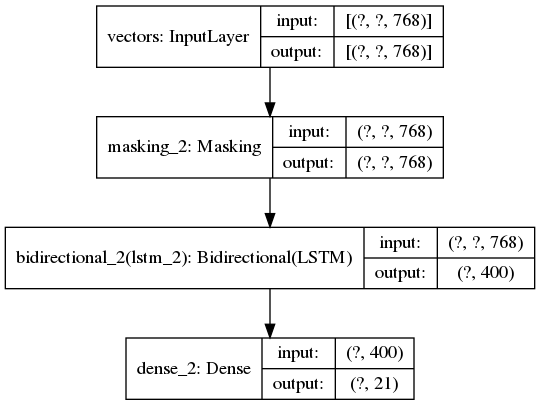

In [115]:
plot_model(lstm(), to_file='model_lstm.png', show_shapes=True)
Image('model_lstm.png')

# Batch generators for Bi-LSTM

Every example may contain different number of vectors, due to question splitting. So we use **batch generators** for training, validation and inference

In [138]:
num_sequences = len(y_train)
timesteps = 10
batch_size = 3
batches_per_epoch =  int(num_sequences/batch_size) #1823
#assert batch_size * batches_per_epoch < num_sequences
num_features= DIM
def train_generator(df,y,):
    x_list= df.to_list()
    y_list =  y
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            #print(len(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:]))
            #timesteps = len(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:])
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  UNITS))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [139]:
num_sequences_val = len(y_hold)
batch_size_val = 8
batches_per_epoch_val = int(num_sequences_val/batch_size_val) #76
assert batch_size_val * batches_per_epoch_val <= num_sequences_val
num_features= DIM
def val_generator(df,y):
    x_list= df.to_list()
    y_list =  y
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            #timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val, UNITS))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                # print("li", li)
                # print(x_train[i, 0:len(x_list[li]), :].shape, len(x_list[li]))
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [140]:
def test_generator(df):
    x_list= df.to_list()
    #y_list =  y
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            #timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            #y_train = np.zeros((batch_size_val, UNITS))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                # print("li", li)
                # print(x_train[i, 0:len(x_list[li]), :].shape, len(x_list[li]))
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                #y_train[i] = y_list[li]
            yield x_train

In [155]:
fold=0
model = lstm()
#checkpoint_path = f'training_models_full/model_bert_lstm_pooled_fold-{fold}_test.h5'
checkpoint_path = f'training_models_2/model_question_lstm_fold-0.h5'

sp = CustomCallback(valid_inputs=df_emb_hold,
                    valid_outputs=y_hold,
                    batch_size=8,
                    patience=6,
                    fold=fold,
                    model_name=checkpoint_path,
                    pred='lstm'
                    )

cp = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                        monitor='val_loss',
                                        save_best_only=True,
                                        save_weights_only=True,
                                        verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=2, mode='auto',
                              patience=3, min_lr=0.0000000)


model.fit(train_generator(df_emb_train,y_train), steps_per_epoch=batches_per_epoch, epochs=100,
                    validation_data=val_generator(df_emb_hold,y_hold), validation_steps=batches_per_epoch_val,
                    callbacks=[sp,reduce_lr],
                    shuffle=True,
                    )

Epoch 1/100
1822/1823 [============================>.] - ETA: 0s - loss: 0.3792
Saving model.. training_models_2/model_question_lstm_fold-0.h5

validation rho: 0.403
1823/1823 [==============================] - 9s 5ms/step - loss: 0.3792 - val_loss: 0.3649
Epoch 2/100
1809/1823 [============================>.] - ETA: 0s - loss: 0.3378
Saving model.. training_models_2/model_question_lstm_fold-0.h5

validation rho: 0.411
1823/1823 [==============================] - 6s 3ms/step - loss: 0.3376 - val_loss: 0.3646
Epoch 3/100
1814/1823 [============================>.] - ETA: 0s - loss: 0.3334
Saving model.. training_models_2/model_question_lstm_fold-0.h5

validation rho: 0.413
1823/1823 [==============================] - 6s 3ms/step - loss: 0.3332 - val_loss: 0.3651
Epoch 4/100
1809/1823 [============================>.] - ETA: 0s - loss: 0.3310
Saving model.. training_models_2/model_question_lstm_fold-0.h5

validation rho: 0.414
1823/1823 [==============================] - 6s 3ms/step - loss

In [156]:
checkpoint_path = 'training_models_2/model_question_lstm_fold-0.h5'
model = lstm()
model.load_weights(checkpoint_path)

In [157]:
preds = model.predict(test_generator(df_emb_hold), steps=76, callbacks=None, max_queue_size=10,
                      workers=1, use_multiprocessing=False, verbose=1)

76/76 [==============================] - 0s 1ms/step


In [158]:
df_emb_hold.shape, preds.shape

((608,), (608, 21))

In [159]:
compute_spearmanr(y_hold, preds)

0.414068103972769

# Final results

So the score (spearman correlation) is:
- Bert finetuned: 0.403
- Bi-LSTM trained on Bert representations: **0.414**